# Proyecto 03 - Series de Tiempo



## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Parte A - Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Parte B - Predicción a Futuro (Machine Learning)

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Parte C - Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### Parte A - Exploración de datos

#### 1. Cargamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set()
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from fbprophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


Importing plotly failed. Interactive plots will not work.


1.1 Carga de los datos

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

1.2 Primera observación de tipos de datos y primeras 5 instancias:

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

1.3 Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

* **periodo**: año del dataset 
* **fecha**: año dia mes
* **hora_inicio**: hora de inicio de la cuenta de vehiculos (DROP)
* **hora_fin**: hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)
* **dia**: dia de la semana 
* **estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)
* **sentido**: Centro o Provincia
* **tipo_vehiculo**: Liviano o Pesado
* **forma_pago**: Hay varias y varian entre los años.
* **cantidad_pasos**: Cantidad de vehiculos

1.4 Corroboro que las variables periodo, dia, y hora_fin tengan valores lógicos:

In [10]:
print(data_2019['periodo'].unique())
print(data_2018['periodo'].unique())
print(data_2017['periodo'].unique())

[2019]
[2018]
[2017]


In [11]:
print(data_2019['dia'].unique())
print(data_2018['dia'].unique())
print(data_2017['dia'].unique())

['Martes' 'Viernes' 'Lunes' 'Miércoles' 'Sábado' 'Jueves' 'Domingo']
['Lunes' 'Martes' 'Miércoles' 'Jueves' 'Viernes' 'Sábado' 'Domingo']
['Domingo' 'Lunes' 'Martes' 'Miércoles' 'Jueves' 'Viernes' 'Sábado']


In [12]:
print(data_2019['hora_fin'].unique())
print(data_2018['hora_fin'].unique())
print(data_2017['hora_fin'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]


1.5 Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**, para ello se concatenan los 3 periodos en una sola tabla y se filtra lo mencionado.

Además, eliminamos las columnas que no aportan información adicional como "hora_inicio" y "periodo":

In [13]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

1.6 Tranformaciones sobre la variable "fecha" para que la misma incluya el "horario final":

In [14]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [15]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

1.7 Reordenamos el dataset por fecha:

In [16]:
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

1.8 Graficamos el dataset obtenido

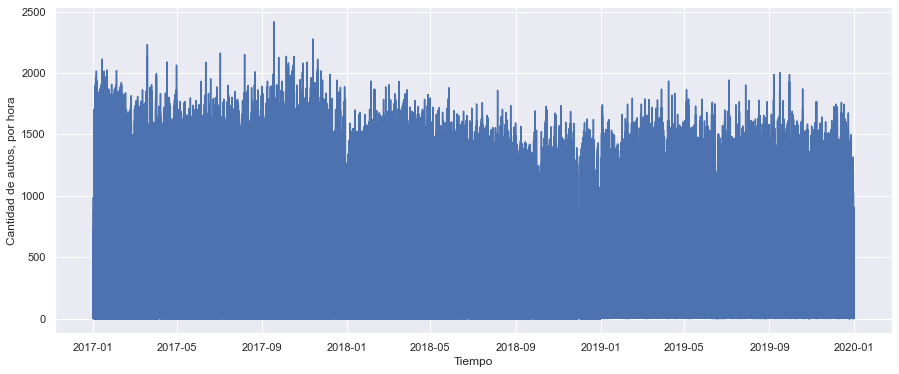

In [17]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

1.9 Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable

In [18]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

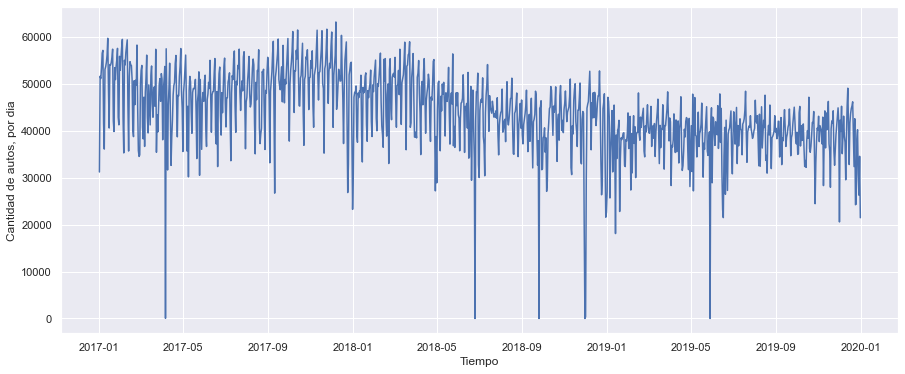

In [19]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

1.10 Análisis de Valores Faltantes:

    1.10.1 Chequeo posibles valores faltantes en FECHA:

In [20]:
diario["fecha"] = diario.index
diario['date_check'] = diario.fecha.diff()
diario.date_check.value_counts()

1 days    1094
Name: date_check, dtype: int64

No se verificaron errores en las fechas observadas ya que por cada observación tenemos un dia de diferencia.

In [21]:
diario.drop(["date_check", "fecha"], axis=1, inplace=True)

    1.10.2 Chequeo posibles valores faltantes en CANTIDAD PASOS:

In [22]:
diario.isna().sum()

cantidad_pasos    0
dtype: int64

No se verificaron missings en las fechas observadas para la variable "cantidad_pasos".

1.11 Tratamiento Anomalías:

    1.11.1 Análisis del Gráfico: A lo largo del gráfico anterior se observan 6 puntos que podrían considerarse anomalos ya que se encuentran muy lejanos a la serie. Es por este motivo que trazo un límite en 10000 para eliminar dichas observaciones y realizar una interpolación de estos datos para suavizar la serie 

In [23]:
diario.cantidad_pasos[diario.cantidad_pasos <= 10000]

fecha
2017-04-06     40
2018-06-25      0
2018-09-25      0
2018-11-30      0
2018-12-01    350
2019-05-29      0
Name: cantidad_pasos, dtype: int64

    1.11.2 ¿Existen motivos que justifiquen estos valores?. Realizamos una recopilación de información en distintos portales de noticias para entender el dataset y sus anomalias:

Para estas fechas sucedieron los siguientes sucesos:
*  2017-04-06: [Paro general de la CGT](https://www.pagina12.com.ar/30044-una-muestra-de-rechazo-al-ajuste-pro)
*  2018-06-25: [Paro general de la CGT](https://www.infobae.com/diarios/2018/06/25/clarin-lunes-25-de-junio-de-2018/)
*  2018-09-25: [Paro general de la CGT](https://www.clarin.com/viajes/paro-general-25-septiembre-operan-aeropuertos_0_0KqpCPX5B.html)
*  2018-11-30: [Comienzo G20 en Argentina](https://www.infobae.com/america/portadas/2018/11/30/clarin-argentina-viernes-30-de-noviembre-de-2018/)
*  2018-12-01: [Continúa G20 en Argentina](https://www.infobae.com/america/portadas/2018/12/01/clarin-argentina-sabado-1-de-diciembre-de-2018/)
*  2019-05-29: [Paro general de la CGT](https://www.perfil.com/noticias/politica/como-se-vive-paro-miercoles-29-de-mayo-en-las-redes-sociales.phtml)

    1.11.3 Decidimos eliminar estas observaciones y realizar estimaciones para completar los nuevos valores faltantes:

In [24]:
diario.cantidad_pasos[diario.cantidad_pasos <= 10000] = np.nan
diario.isna().sum()

cantidad_pasos    6
dtype: int64

Hecho esto, debemos completar la serie mediante alguna metodología. Se opta por utilizar el método interpolate:

In [25]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


    1.11.4 Re-graficar la serie: vemos una mayor concentración de los datos 

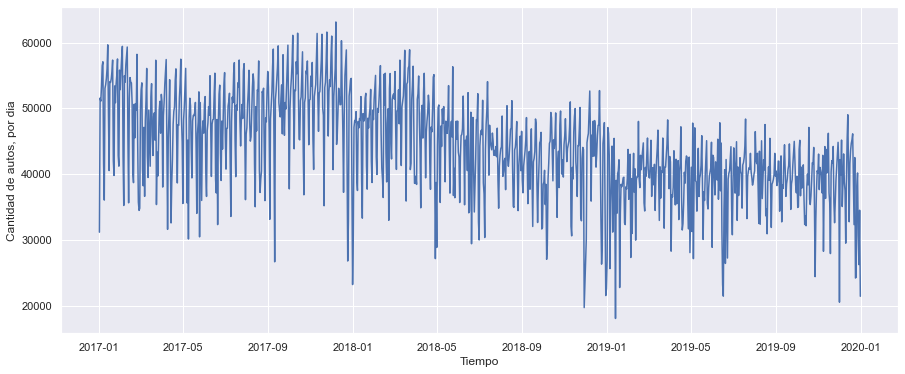

In [26]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

1.12 Descomposición de la Serie:

Algunas series se comportan como $Tendencia + Estacionalidad + Ruido$, mientras que otras tienen comportamientos más complejos, como $Tendencia * Estacionalidad * Ruido$. Se encuentran diferentes técnicas para obtener estos componentes:
        
    1.12.1 Metodología manual: Debemos realizar los siguientes pasos
        
        * Obtener la **tendencia** a través de *medias móviles*: Consiste en tomar una ventana de tiempo suficientemente grande y promediar la serie sobre esa ventana. Una ventaja de este método es que no asume ninguna forma para la serie de tiempo así que suele funcionar en muchos casos.

        * Una vez que estimada la tendencia, voy a tomar la serie original, restarle la tendencia y obtener una nueva serie sin tendencia, donde esperamos que sea la componente **estacional** la que domine. Luego, para obtener componentes **estacionales**, se suele asumir una forma armónica (tipo seno o coseno). Es decir, se puede hacer un procedimiento similar al que hecho con la tendencia (ajustar y restar a la serie sin tendencia) para obtener **ruido + componentes restantes**.


    1.12.2 Librería Statsmodel:
    
    A través de Statsmodels, que cuenta con muchas herramientas para análisis estadísticos, el método seasonal_decompose realiza el trabajo por nosotros, obteniendo cada componente de la serie.
    
    
Realizaremos cada método para elegir uno y describir el comportamiento de la serie, comenzaremos con la metodología manual, tomando una ventana semanal para la estimación de la tendencia (realizaremos tanto la metodología aditiva como la multiplicativa en cada caso):
    
1.12.1.1 Metodología manual: Obtendremos la Tendencia a través de la media movil semanal, metodología aditiva (Tendencia + Estacionalidad + Ruido)

In [27]:
ventana = int(365/(52))
tendencia_semanal = diario.cantidad_pasos.rolling(window=ventana, center = False).mean()
tendencia_semanal

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04             NaN
2017-01-05             NaN
                  ...     
2019-12-27    34441.428571
2019-12-28    33209.714286
2019-12-29    32341.428571
2019-12-30    31197.428571
2019-12-31    30801.285714
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

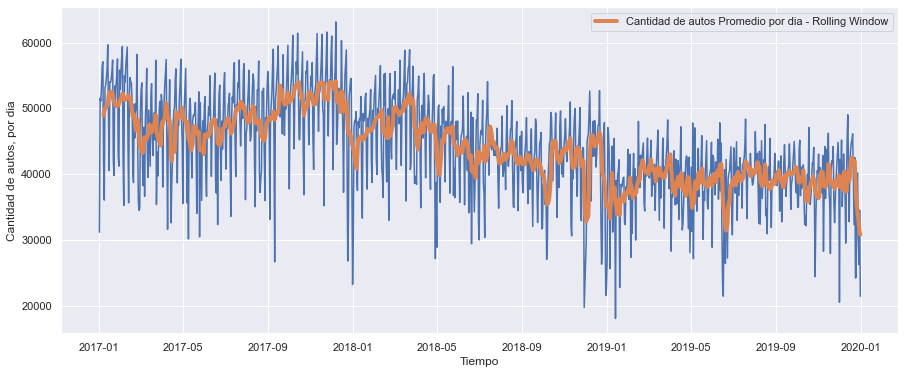

In [28]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.plot(tendencia_semanal, lw = 4, label = 'Cantidad de autos Promedio por dia - Rolling Window')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.legend()
plt.show()

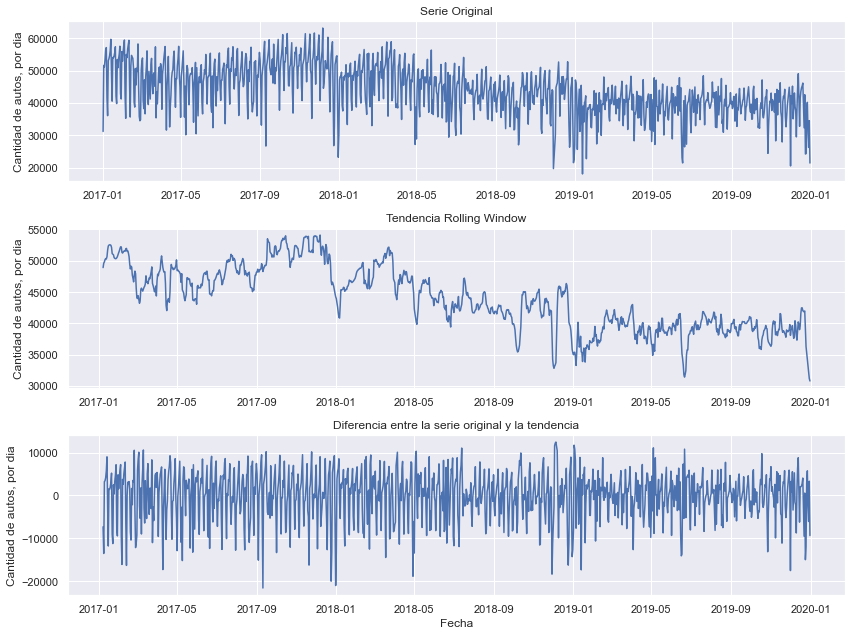

In [29]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(tendencia_semanal)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos - tendencia_semanal)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por dia')

plt.tight_layout()
plt.show()

1.12.1.2 Metodología manual: Obtendremos la Tendencia a través de la media movil semanal, metodología multiplicativa (Tendencia * Estacionalidad * Ruido)

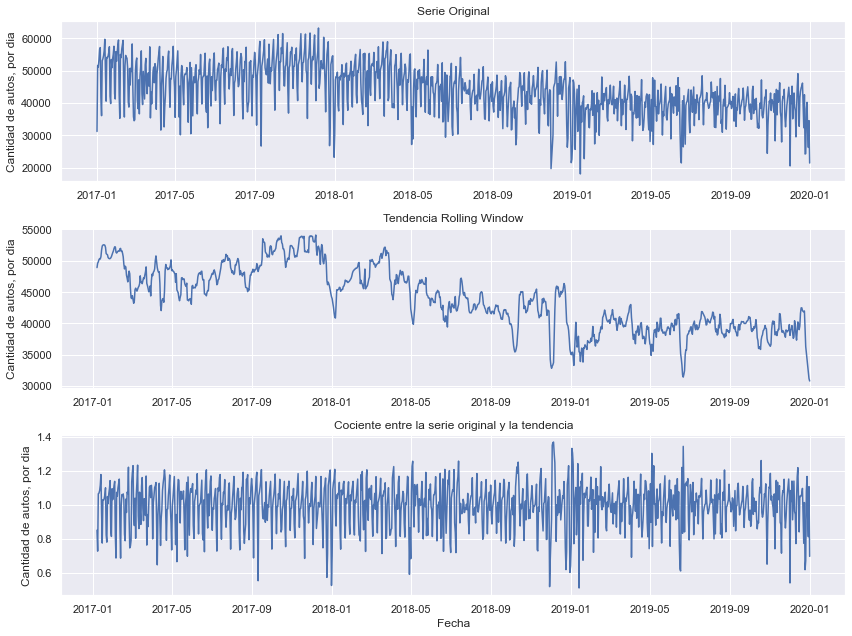

In [30]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(tendencia_semanal)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,3)
plt.title('Cociente entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos / tendencia_semanal)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por dia')

plt.tight_layout()
plt.show()

1.12.2 Utilizando librerías

1.12.2.1 Tendencia, Estacionalidad y Ruido: metodología aditiva (Tendencia + Estacionalidad + Ruido)

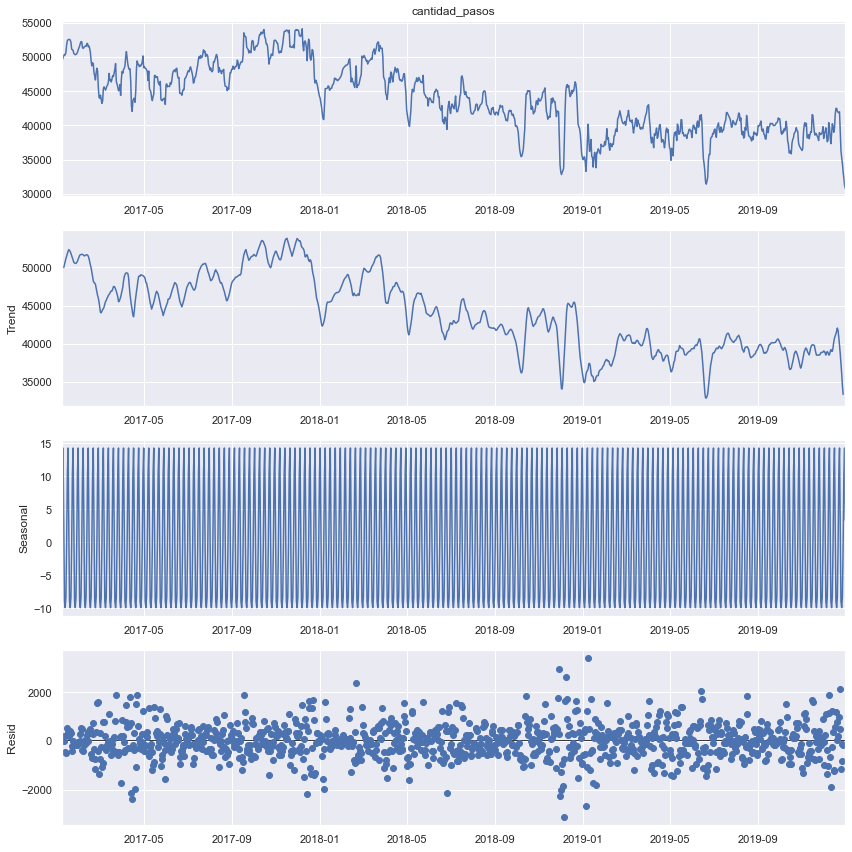

In [31]:
result = seasonal_decompose(tendencia_semanal.dropna(), model='additive')

matplotlib.rcParams['figure.figsize'] = [12,12]

result.plot()
plt.show()

Voy a utilizar esta metodologia para decribir a la serie diaria.

Tomando en consideración a la tendencia, se observa una caida en el primer trimestre de 2017 que luego remonta con una tendencia positiva hasta finales del mismo año. En los ultimos dias del año 2017 se ve un desplome fuerte en la serie, que al comienzar el año 2018 recupera en todo el primer trimestre, sin poder llegar a niveles vistos en 2017. 

Una vez finalizado este trimestre, vemos claramente como a partir de ese momento, se ve una tendencia negativa a grandes rasgos con altibajos bastante grandes.

Al observar el año 2019, vemos una pequeña suba a comienzos de año, que luego se mantiene en el tiempo, como si la tendendia fuera nula.

Luego pasando por el gráfico seasonal, vemos la variabilidad que otroga este componente a la serie (variabilidad constante).

Por último, vemos que para los residuos hay períodos de gran concentración de datos (2018-09) y luego períodos como 2019-01 en donde la variabilidad es grande.

Veremos a continuación un histograma de la serie de residuos y esperamos tenes una distribución similar a la normal

(array([  2.,  10.,  32., 167., 451., 312.,  72.,  32.,   3.,   2.]),
 array([-3144.93249049, -2486.99192433, -1829.05135817, -1171.11079201,
         -513.17022585,   144.77034032,   802.71090648,  1460.65147264,
         2118.5920388 ,  2776.53260496,  3434.47317112]),
 <a list of 10 Patch objects>)

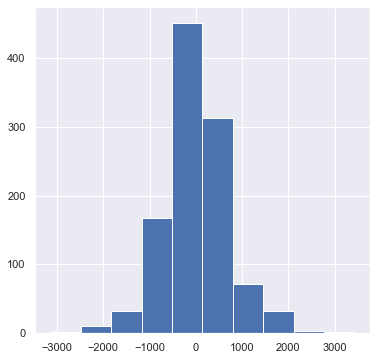

In [32]:
matplotlib.rcParams['figure.figsize'] = [6,6]
plt.hist(result.resid)

A modo informativo se detallan las metodologias restantes para descomponer una serie de tiempo:

1.12.2.1 Tendencia, Estacionalidad y Ruido: A través de Statsmodels, que cuenta con muchas herramientas para análisis estadísticos, metodología multiplicativa (Tendencia * Estacionalidad * Ruido)

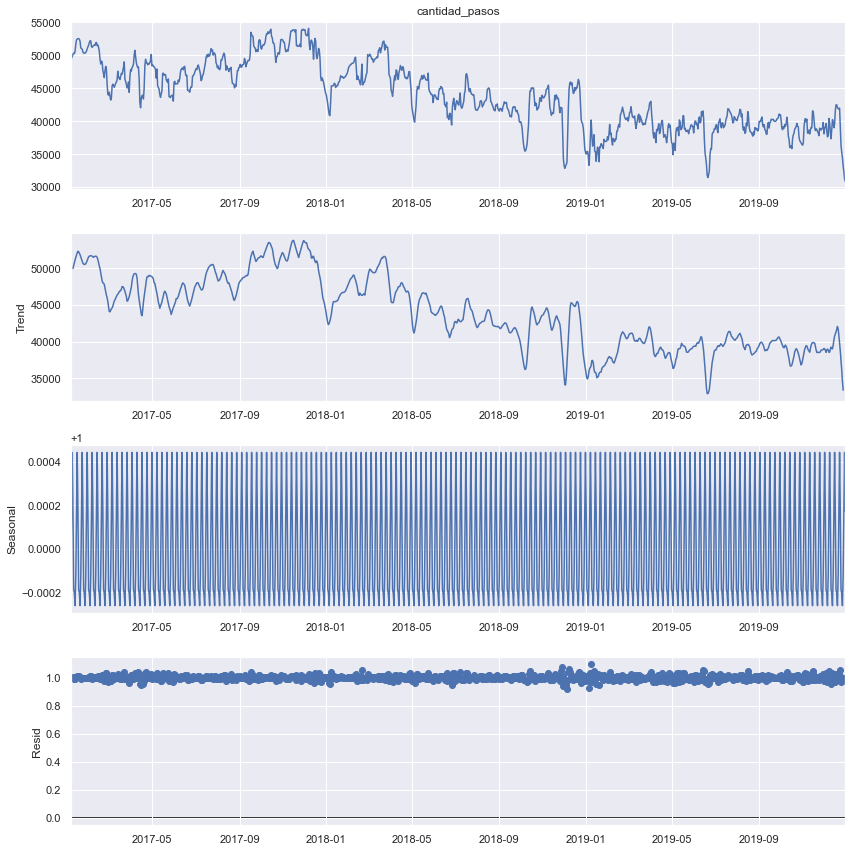

In [33]:
result = seasonal_decompose(tendencia_semanal.dropna(), model='multiplicative')
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

(array([  2.,   6.,  23., 146., 502., 320.,  65.,  16.,   1.,   2.]),
 array([0.91468203, 0.93255373, 0.95042543, 0.96829713, 0.98616883,
        1.00404053, 1.02191223, 1.03978393, 1.05765563, 1.07552734,
        1.09339904]),
 <a list of 10 Patch objects>)

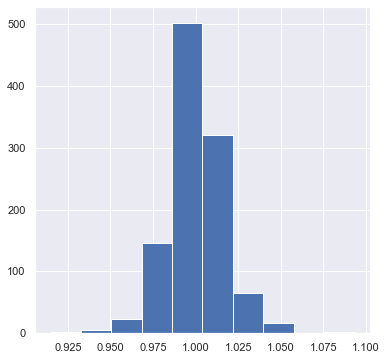

In [34]:
matplotlib.rcParams['figure.figsize'] = [6,6]
plt.hist(result.resid)

    1.12.3 Tendencia considerando 15 dias para la media movil
        
        1.12.3.1 Manual, Aditiva:

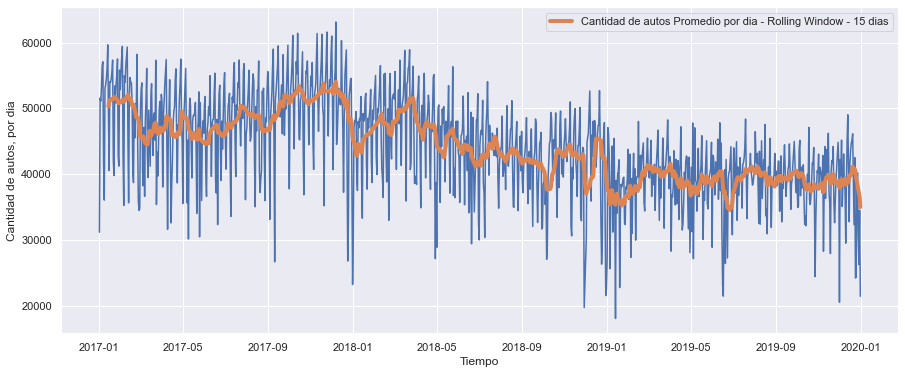

In [35]:
ventana = int(365*2/(52))
tendencia_15d = diario.cantidad_pasos.rolling(window=ventana, center = False).mean()
tendencia_15d
matplotlib.rcParams['figure.figsize'] = [12,12]

plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.plot(tendencia_15d, lw = 4, label = 'Cantidad de autos Promedio por dia - Rolling Window - 15 dias' )
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.legend()
plt.show()

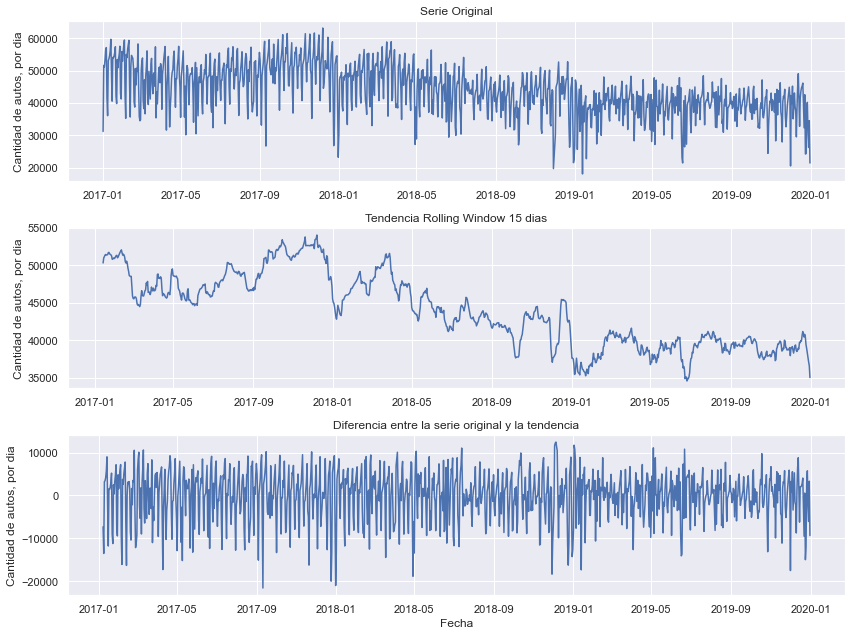

In [36]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window 15 dias')
plt.plot(tendencia_15d)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos - tendencia_semanal)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por dia')

plt.tight_layout()
plt.show()

        1.13.3.2 Manual, Multiplicativa

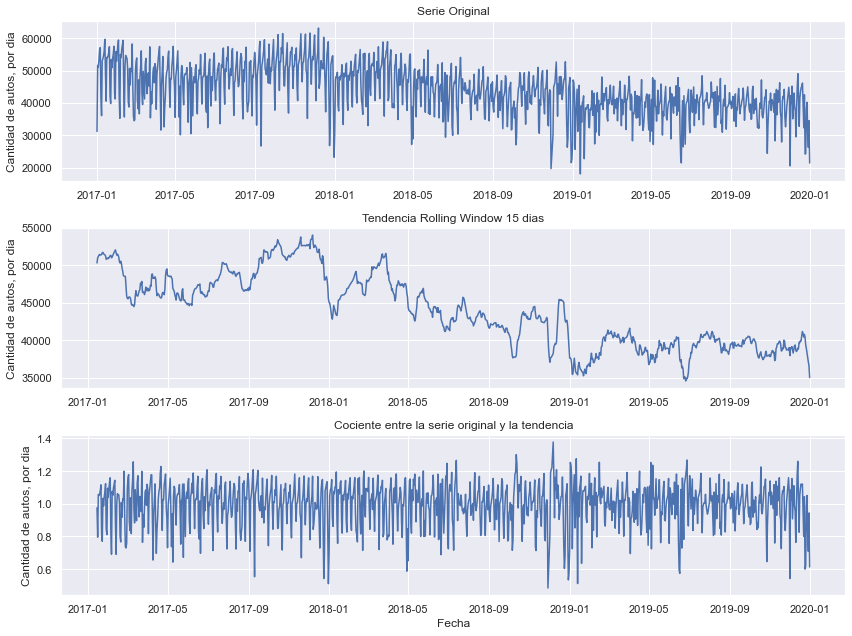

In [37]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window 15 dias')
plt.plot(tendencia_15d)
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(3,1,3)
plt.title('Cociente entre la serie original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos / tendencia_15d)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de autos, por dia')

plt.tight_layout()
plt.show()

        1.13.3.3 Statsmodels, aditiva

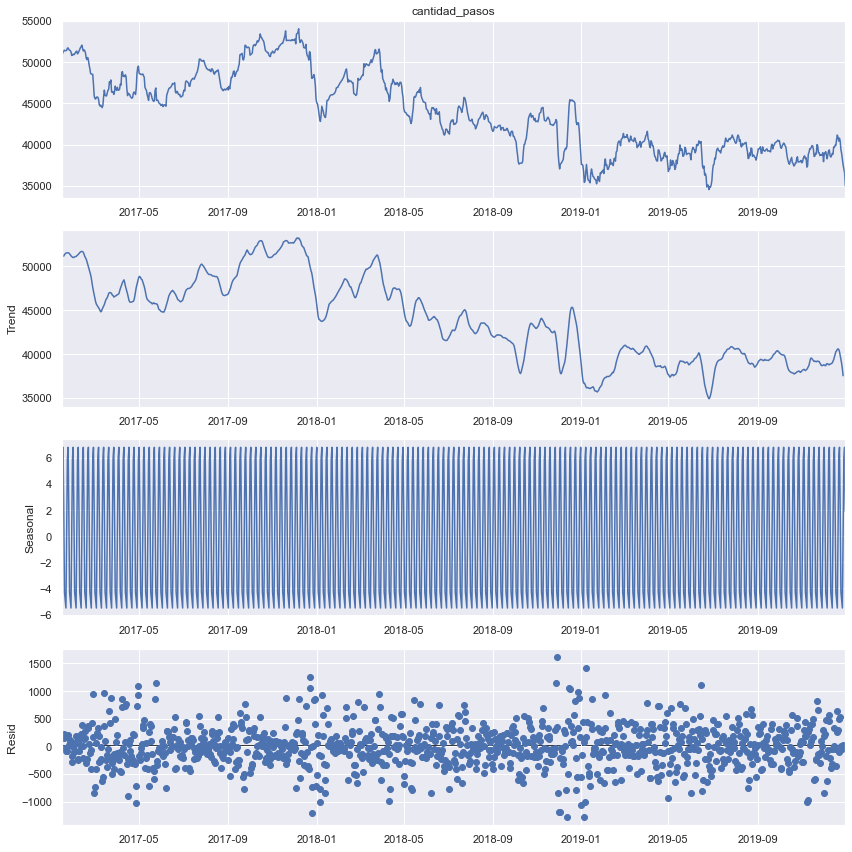

In [38]:
result = seasonal_decompose(tendencia_15d.dropna(), model='additive')

result.plot()
plt.show()

(array([ 10.,  28.,  77., 247., 401., 217.,  61.,  26.,   7.,   2.]),
 array([-1285.18324949,  -994.20976022,  -703.23627096,  -412.26278169,
         -121.28929243,   169.68419684,   460.6576861 ,   751.63117537,
         1042.60466464,  1333.5781539 ,  1624.55164317]),
 <a list of 10 Patch objects>)

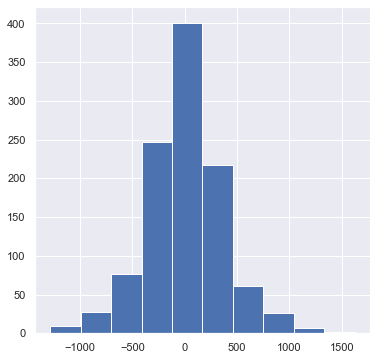

In [39]:
matplotlib.rcParams['figure.figsize'] = [6,6]
plt.hist(result.resid)

        1.13.3.3 Statsmodels, multiplicativa

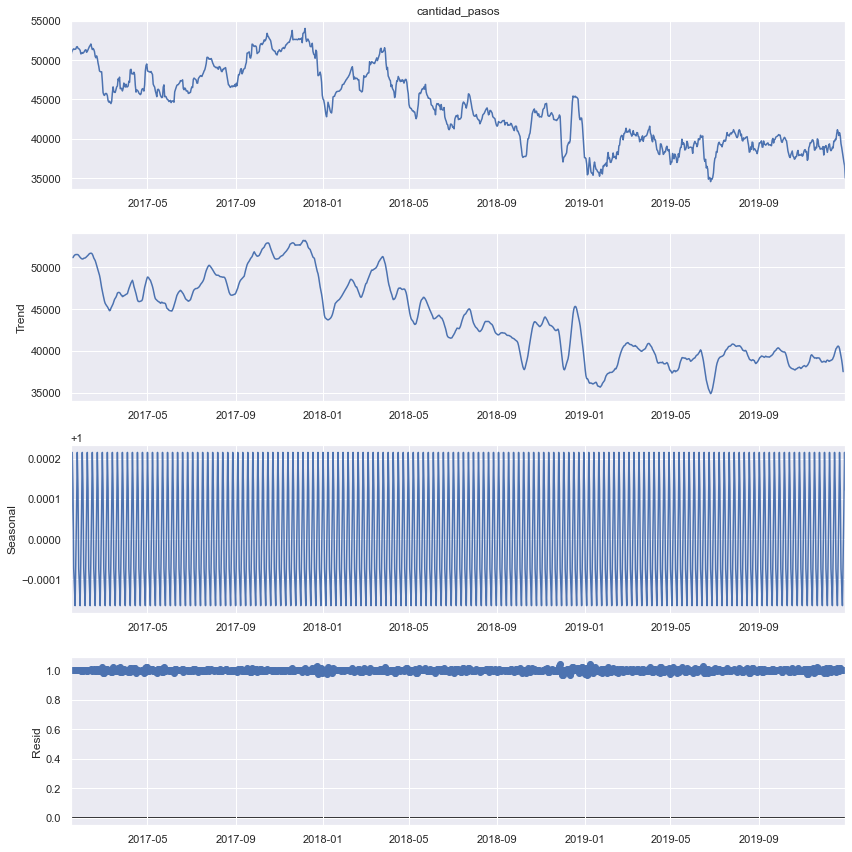

In [40]:
result = seasonal_decompose(tendencia_15d.dropna(), model='multiplicative')
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

(array([  5.,  12.,  60., 161., 455., 262.,  86.,  28.,   5.,   2.]),
 array([0.96503969, 0.9724745 , 0.9799093 , 0.98734411, 0.99477892,
        1.00221372, 1.00964853, 1.01708334, 1.02451814, 1.03195295,
        1.03938776]),
 <a list of 10 Patch objects>)

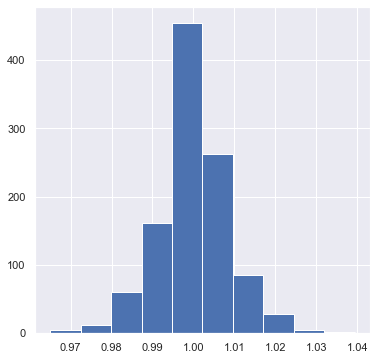

In [41]:
matplotlib.rcParams['figure.figsize'] = [6,6]
plt.hist(result.resid)

1.14 Autocorrelación: ¿Depende de sí misma en el tiempo la variable "cantidad de pasos"?

    1.14.1 Generamos un gráfico que exprese a la variable frente a la observación anterior

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


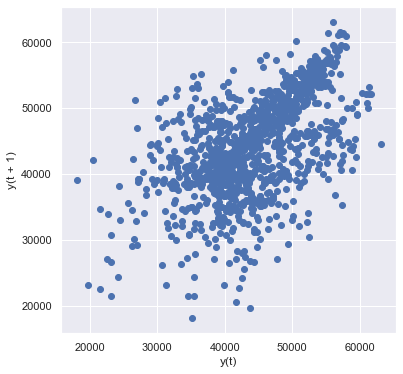

In [42]:
pd.plotting.lag_plot(diario, lag=1)

1.14.2 Cuando se quiere analizar la serie de tiempo es necesario identificar la estructura que la genera, es decir cómo influyen las observaciones del pasado en las observaciones del futuro. Para identificar esta dependencia utilizamos dos fuentes de información, la Función de Autocorrelación Simple (FAS) y la Función de Autocorrelación Parcial (FAP), a saber: 
    
* Función de Autocorrelación Simple (FAS): La función de autocorrelación simple se una serie proporciona la estructura de dependencia lineal de la misma.
    Si denominamos zt a la serie temporal, los valores que se observan van a ser:
        z1, z2, ..., zt−2, zt−1, zt, zt+1, ...
        
    Donde z1 representa el primer valor de la serie, z2 el segundo, y zt será el valor actual de la serie.
    De este modo zt+1 representa el valor de la serie para próximo periodo, es decir un valor futuro.
    
    Si denominamos z1 influye sobre z2 como z1 -> z2, la función de autocorrelación simple tiene por objetivo estudiar cómo se influyen las diversas observaciones:
    
    z1 -> z2 -> ... -> zt−1 -> zt -> zt+1 -> ...
    
    La idea de la función de autocorrelación es proporcionar el coeficiente de correlación entre las observaciones separadas un número determinado de periodos. Así la FAS, va a ser una sucesión de números
    
    p1,p2, ...,  pk, ...

    que representan cómo influye una observación sobre la siguiente (p1), sobre la segunda posterior (p2) o sobre la k periodos posterior (pk).

    Los coeficientes de la FAS, p1, p2, ..., pk están acotados entre [−1,+1]. 

        * Cuando un pi vale cero, quiere decir que no existe efecto entre una observación y la i posiciones posterior.
        * Si pi es próximo a 1 indica que hay mucha relación entre una observación y la i posiciones posterior, y que esa relación es positiva.
        * Si pi es próximo a -1 indica que hay mucha relación entre una observación y la i posiciones posterior, y que esa relación es negativa.

    La FAS proporciona cómo una observación influye sobre las posteriores.

    Este gráfico puede llamar tambien como correlograma.

Text(0.5, 0, 'lag')

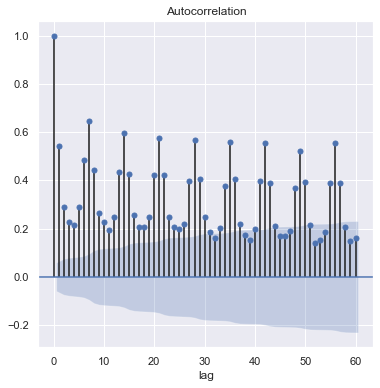

In [43]:
plot_acf(diario, lags=60)
plt.xlabel('lag')

* Como puede observarse la función de autocorrelación proporciona los coeficientes de correlación de la serie consigo misma -de ahí el nombre de Autocorrelación- para distintos retardos. 
    
    Es el caso de la figura, se ve que los coeficientes (o palos de la función) son significativos para casi todos los retardos. Las bandas mas oscuras que se observan en la figura proporcionan los límites para considerar significativo un retardo. Es decir si un palo está dentro de las bandas lo consideraremos no significativo en general. 
    
    La FAS tiene un problema, y es que si por ejemplo p1 es distinto de cero, entonces

    z1 -> z2 -> ... -> zt−1 -> zt -> zt+1 -> ...

    es decir existe una cadena de influencia separada por un retardo. Pero si z1 -> z2 y z2 -> z3, entonces z1 -> z3. Por tanto, la FAS en general, si p1 es distinto de cero, encontrará que p2,p3,... etc, serán distintos de cero.
    Sin embargo es necesario distinguir entre varias cadenas de influencia posibles:
    
    * La cadena de influencia general, a través de p1.
    * Las cadenas de influencia directa. Es decir cómo influye z1 sobre z3 directamente, es decir SIN PASAR A TRAVÉS DE z2.

    Para resolver este problema se construye la Función de Autocorrelación Parcial.

* Función de Autocorrelación Parcial (FAP): proporciona la relación directa que existe entre observaciones separadas por k retardos. 
    Esta es una información muy valiosa sobre la estructura de la serie, ya que elimina el problema que presentaba la función de autocorrelación simple de que si z1 -> z2 y z2 -> z3, entonces z1 -> z3. 
    En la función de autocorrelación simple, el primer palo (relación entre z1 y z2 o z2 y z3) será significativo. Y el segundo también, ya que si z1 -> z2 y z2 -> z3, entonces z1 -> z3. 
    En la FAP, esto no ocurre. el primer palo, será significativo, y el segundo no lo será.

Text(0.5, 0, 'lag')

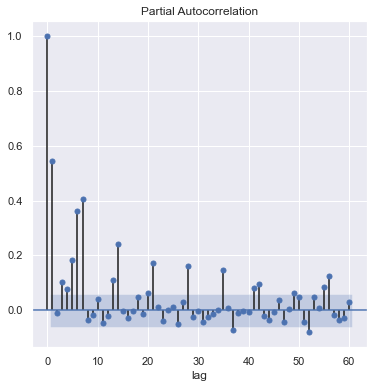

In [44]:
plot_pacf(diario, lags= 60)
plt.xlabel('lag')

Si los valores se encuentran fuera de las zonas mas oscuras, quiere decir que con un 95% de confianza, podemos afirmar que existe dependencia de la variable en el tiempo o autocorrelación. Esto implica que se trata de una serie **no estacionaria en media**.

Para corroborar esto, planteamos el siguiente test estadistico:

#### La prueba de Dickey-Fuller Aumentada

Es un tipo de prueba estadística llamada prueba de raíz unitaria. La intuición detrás de la prueba de raíz unitaria es que determina cuán fuertemente una serie de tiempo está definida por una tendencia.

Utiliza un modelo autorregresivo y optimiza un criterio de información a través de múltiples valores de retraso diferentes.
El procedimiento para la prueba de ADF es la misma que para la prueba de Dickey-Fuller pero se aplica al modelo:

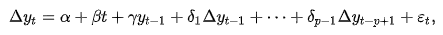

donde $\alpha$  es una constante, $\beta$ el coeficiente sobre una tendencia temporal y $p$ el orden de retraso del proceso autorregresivo. 

* **Hipótesis nula (H0)**: Si se acepta, sugiere que la serie de tiempo tiene una raíz unitaria, lo que significa que no es estacionaria. Tiene una estructura dependiente del tiempo.

* **Hipótesis Alternativa (H1)**: La hipótesis nula es rechazada; sugiere que la serie de tiempo no tiene una raíz unitaria, lo que significa que es estacionaria. No tiene una estructura dependiente del tiempo
estructura.

Interpretamos este resultado usando el valor p de la prueba.

* **Valor p > 0,05**: Aceptamos la hipótesis nula (H0), el dato tiene una raíz unitaria y no es estacionario.
* **Valor p ≤ 0,05**: Rechazar la hipótesis nula (H0), el dato no tiene una raíz unitaria y es estacionario.

La librería Statsmodels provee la función adfuller() que realiza el test:

In [45]:
result = adfuller(diario.cantidad_pasos.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.752326
p-value: 0.404374
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Comparando el p-value de la prueba con 0.05, indica que tendríamos que aceptar la hipótesis nula que la serie de tiempo no es estacionaria y tiene una estructura dependiente del tiempo.

Por este motivo, si queremos realizar estimaciones con modelos tipo ARIMA (Modelos AutoRegresivos Integrados de Media Moviles), debemos transformar la serie tomando diferencias entre la variable en el momento t y la variable en el momento t-1, ya que para realizar estimaciones sobre series de tiempo debemos trabajar con series estacionarias en media:

In [46]:
result = adfuller(diario.cantidad_pasos.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.512394
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


La serie diferenciada nos devuelve valores para este test que indican que tendríamos que aceptar la hipótesis alternativa que la serie de tiempo es estacionaria en media.

Text(0.5, 0, 'lag')

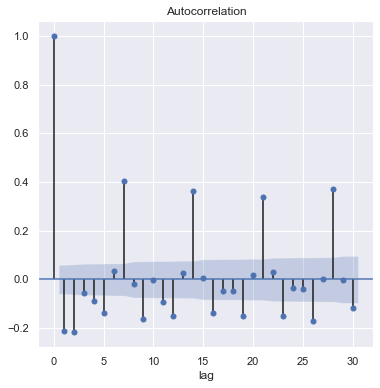

In [47]:
plot_acf(diario.diff(1).dropna(), lags=30)
plt.xlabel('lag')

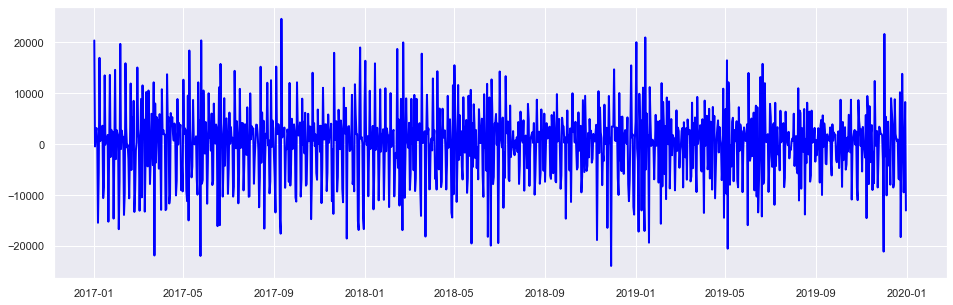

In [48]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.plot(diario.index, diario.cantidad_pasos.diff(),
         color='blue', lw=2, label="train")

## Parte B - Predicción a Futuro (Machine Learning)

#### Consigna: Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019.

* Tomaremos como métrica para comparar los modelos a desarrollar, a la Raíz del  Error Cuadrático Medio (RMSE).
* Intentaremos predecir la cantidad de pasos diarios en la autopista Illia que sean pagos en efectivo con la información histórica de los pasos bajo esta condición.

2.1 Metodología de "Estimar el valor futuro repitiendo el valor observado hoy" (Banchmark):

Observations: 1095
Training Observations: 973
Testing Observations: 122


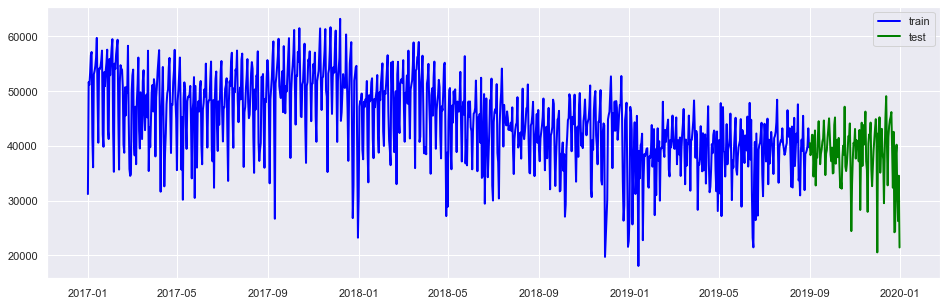

In [49]:
diario.cantidad_pasos = diario.cantidad_pasos.dropna()
train_size = int(len(diario.cantidad_pasos) * 0.889)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.show()

In [50]:
look_back = 90 # usamos 90 datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(883, 90) (883,)
(121, 90) (121,)


In [51]:
diario.cantidad_pasos.index[N_train+look_back: length_total]

DatetimeIndex(['2019-09-01', '2019-09-02', '2019-09-03', '2019-09-04',
               '2019-09-05', '2019-09-06', '2019-09-07', '2019-09-08',
               '2019-09-09', '2019-09-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='fecha', length=122, freq='D')

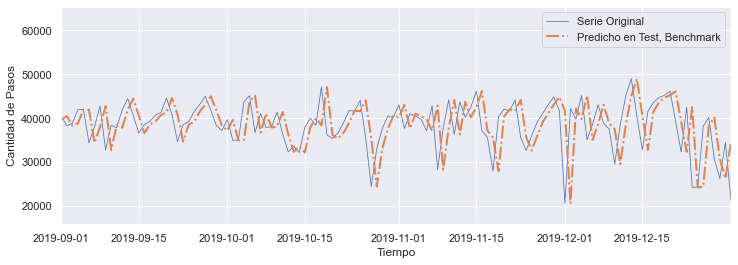

In [52]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

plt.figure(figsize=(12,4))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(diario.cantidad_pasos.index[N_train+look_back], diario.cantidad_pasos.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

In [53]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 2]
MSE = mean_squared_error(y_test, y_test_pred_benchmark)
print('Error en Test en Benchmark:',np.sqrt(MSE))

Error en Test en Benchmark: 6220.128589460309


    2.2 One-Step Prediction

Vamos a entrenar un RandomForestRegressor para predecir el siguiente valor en la serie de tiempo diaria de pasos en efectivo para la estación Illia. Utilizaremos datos desde 2017-01-01 hasta 2019-08-31 como conjunto de entrenamiento. Y el último trimestre del 2019 como test.

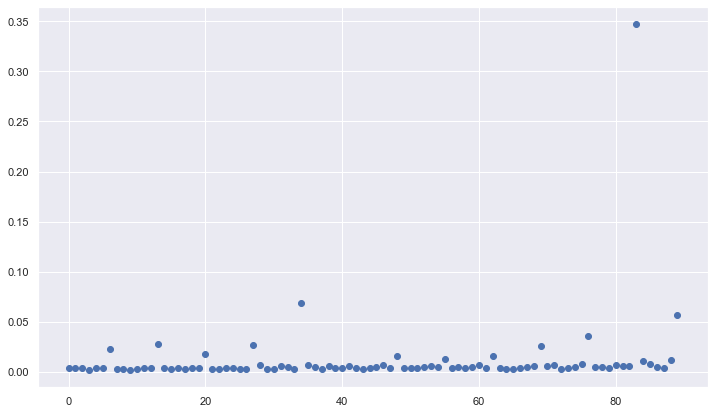

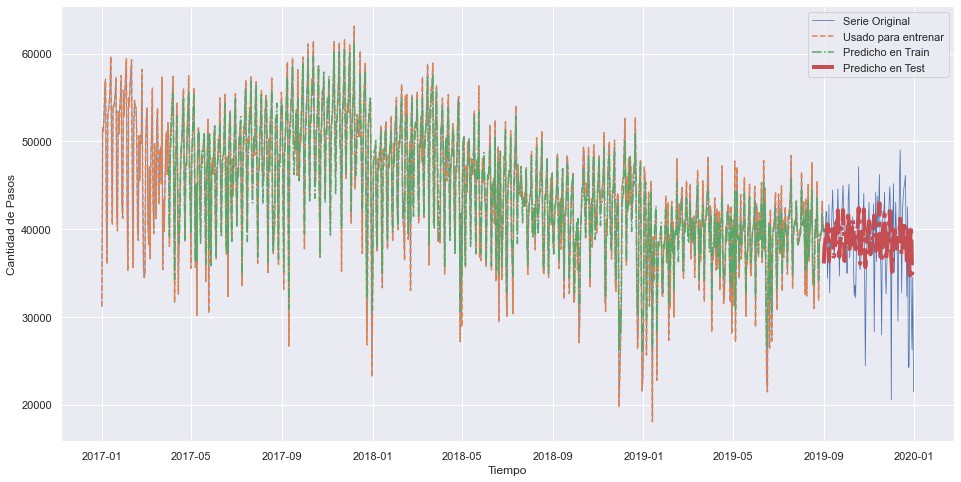

In [54]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)

plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)

y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [55]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 1782.084303782733
Error en Test: 4398.862895314608


# Este es el modelo ganador

    2.3 Multi-Step Prediction
Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [56]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

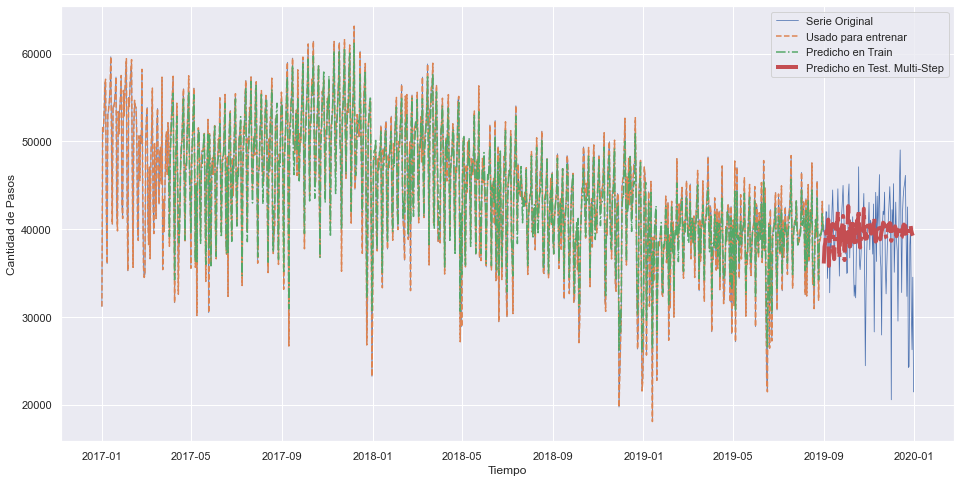

In [57]:
plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [58]:
MSE = mean_squared_error(y_test, y_ms_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Test: 4926.295891803936


    2.3 Metodología Prophet

In [59]:
diario["ds"] = diario.index
diario["y"] = diario.cantidad_pasos

diario.drop(["cantidad_pasos"],axis=1, inplace=True)
diario.reset_index(drop=True, inplace=True)
diario

ds        y
0    2017-01-01  31183.0
1    2017-01-02  51568.0
2    2017-01-03  51093.0
3    2017-01-04  53332.0
4    2017-01-05  56486.0
...         ...      ...
1090 2019-12-27  40182.0
1091 2019-12-28  30681.0
1092 2019-12-29  26259.0
1093 2019-12-30  34523.0
1094 2019-12-31  21447.0

[1095 rows x 2 columns]

In [60]:
diario[diario.ds == "2019-08-31"]

ds        y
972 2019-08-31  39703.0

In [61]:
train = diario.loc[:972,:]
test = diario.loc[973:,:]

In [62]:
prophet = Prophet()
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
y_train_pred = prophet.predict(train)
y_test_pred = prophet.predict(test)
y_train = train["y"]
y_test = test["y"]

In [64]:
MSE_tr = mean_squared_error(y_train, y_train_pred["yhat"])
print('Error en Train:',np.sqrt(MSE_tr))

MSE_te = mean_squared_error(y_test, y_test_pred["yhat"])
print('Error en Test:',np.sqrt(MSE_te))

Error en Train: 4692.623644402622
Error en Test: 5730.330223173638


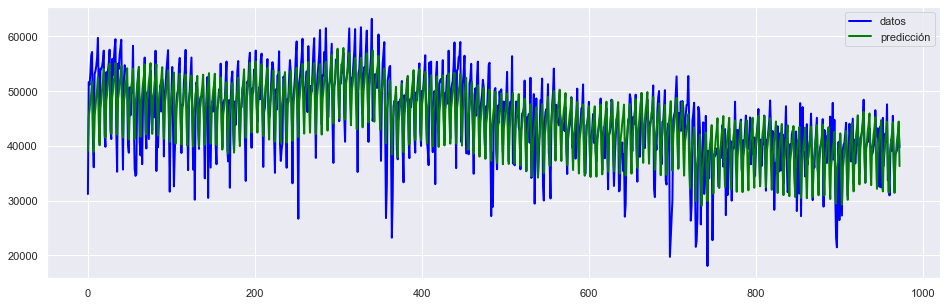

In [65]:
plt.plot(y_train.index, y_train,
         color='blue', lw=2, label="datos")
plt.plot( y_train_pred.index,  y_train_pred["yhat"],
         color='green', lw=2, label="predicción")
plt.legend()
plt.show()

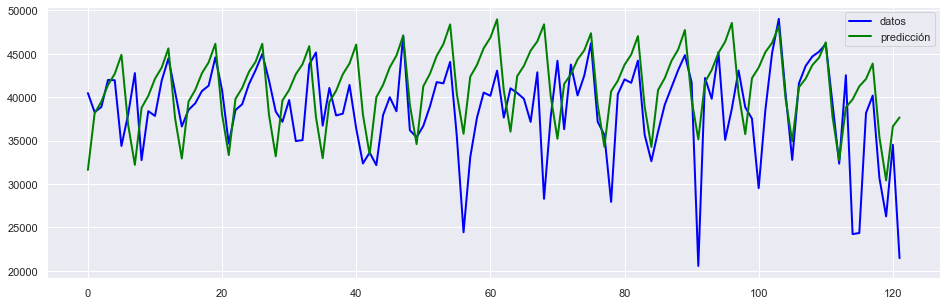

In [66]:
plt.plot(y_test_pred.index, y_test,
         color='blue', lw=2, label="datos")
plt.plot(y_test_pred.index,  y_test_pred["yhat"],
         color='green', lw=2, label="predicción")
plt.legend()
plt.show()

2.4 One-step Prediction optimizada mediante GridSearchCV:
    
* Debemos tener a consideración que la implementación de Cross-Validation tal y como la conocemos no es recomendable aplicarla (tomar valores aleatorios dentro de nuestra data de train). En series de tiempo esta toma de valores debe ser secuencial ya que el tiempo vital en nuestro analisis.
* En Python solucionamos este problema mediante la metodo dentro de sklearn.model_selection llamada TimeSeriesSplit.    

Observations: 1095
Training Observations: 973
Testing Observations: 122


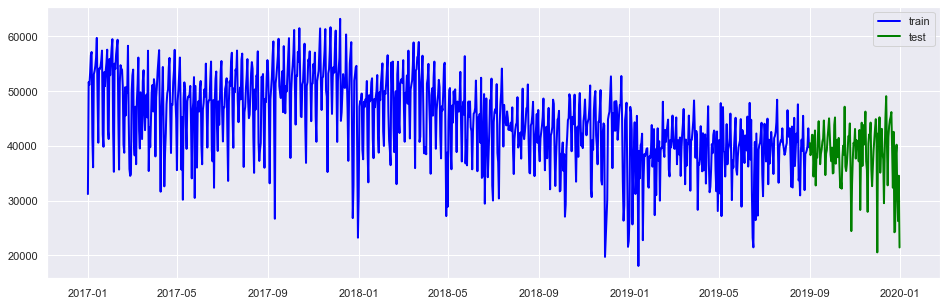

In [67]:
diario["cantidad_pasos"] = diario.y
diario.index= diario.ds
diario.drop(["ds","y"], axis=1, inplace=True)

train_size = int(len(diario.cantidad_pasos) * 0.889)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.show()

2.4.1 Probaré con 90 días de look back

In [68]:
look_back = 90 # usamos 90 datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

tuned_parameters = {'n_estimators': [500, 700, 1000], 
                    'max_depth': [None,1, 2, 3], 
                    'min_samples_split': [1, 2, 3]}

tscv = TimeSeriesSplit(n_splits=10)

clf = GridSearchCV(RandomForestRegressor(random_state=42), tuned_parameters, cv=tscv, n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

print(clf.best_estimator_)

(121, 90) (121,)
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.8min finished


RandomForestRegressor(min_samples_split=3, n_estimators=700, random_state=42)


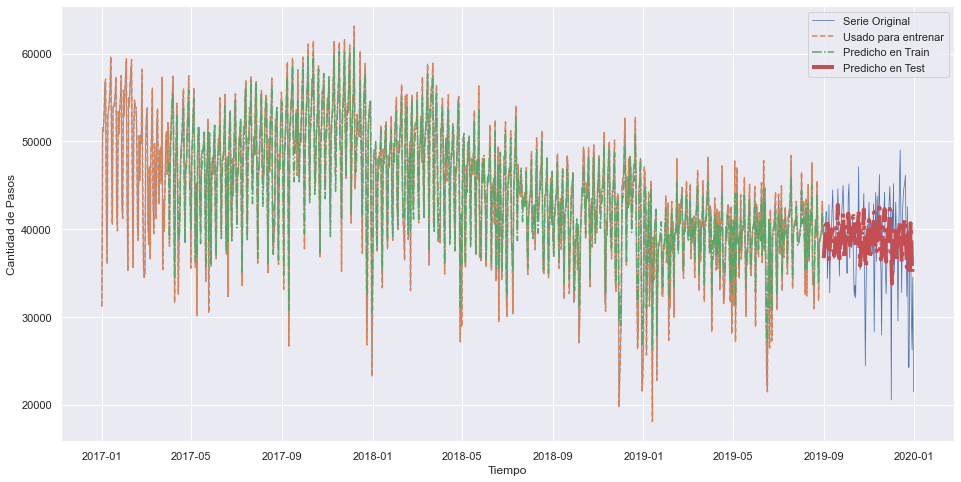

Error en Train: 1809.5231820137071
Error en Test: 4410.220395874984


In [69]:
y_pred = clf.predict(X)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

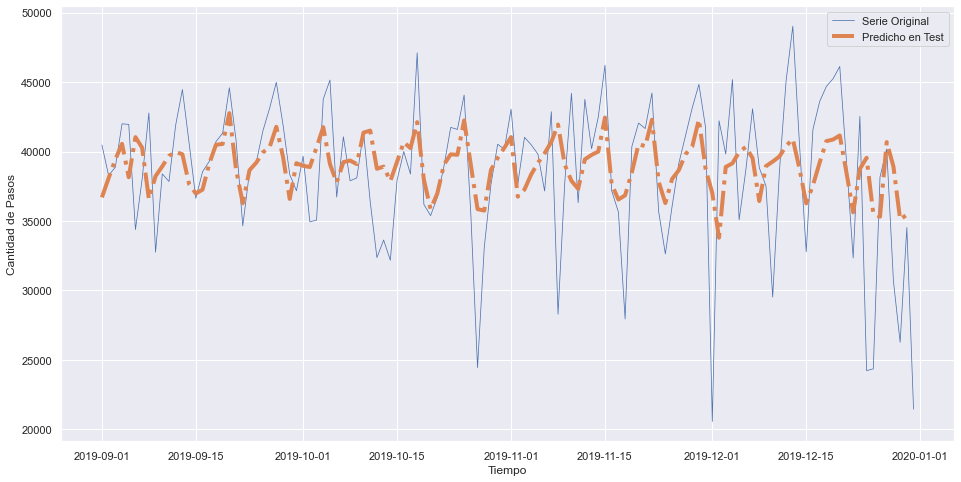

In [70]:
plt.figure(figsize=(16,8))
plt.plot(test.index[:length_total],test[:length_total],lw = 0.75, label = 'Serie Original')
#plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

2.4.2 Realizaré la misma estimación pero con una ventana mayor

In [71]:
look_back = 120 # usamos 120 datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(121, 120) (121,)


In [72]:
tuned_parameters = {'n_estimators': [500, 700, 1000], 
                    'max_depth': [None,1, 2, 3], 
                    'min_samples_split': [1, 2, 3]}

tscv = TimeSeriesSplit(n_splits=10)

clf = GridSearchCV(RandomForestRegressor(random_state=42), tuned_parameters, cv=tscv, n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

print(clf.best_estimator_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.6min finished


RandomForestRegressor(n_estimators=1000, random_state=42)


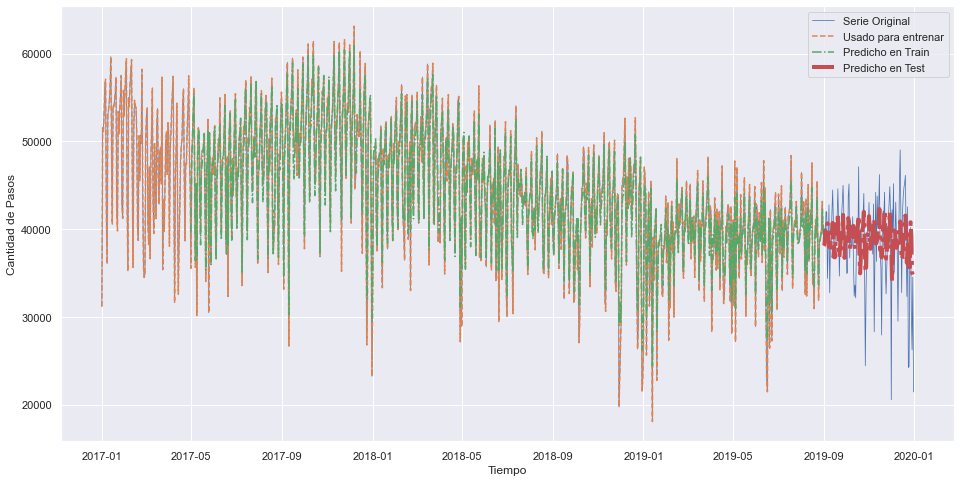

In [73]:
y_pred = clf.predict(X)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [74]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Error en Test:',np.sqrt(MSE))

Error en Train: 1753.2872210364023
Error en Test: 4421.33430167088


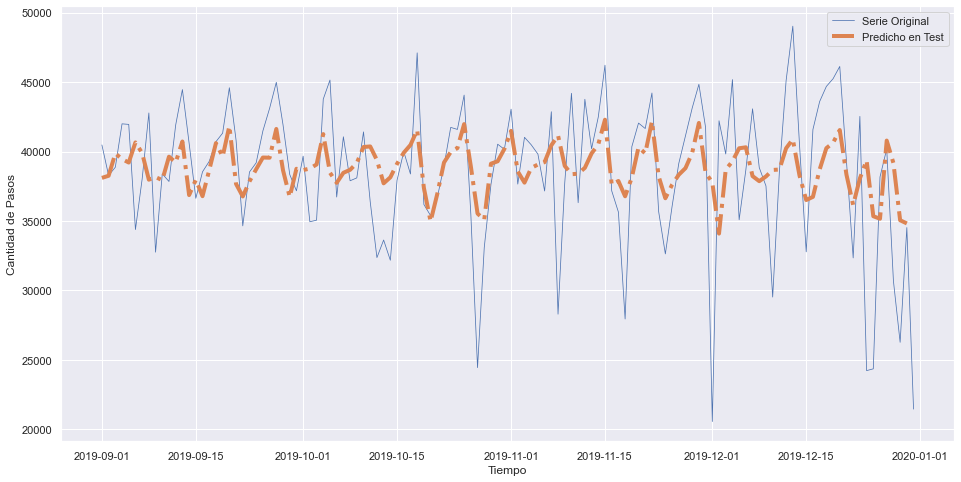

In [75]:
plt.figure(figsize=(16,8))
plt.plot(test.index[:length_total],test[:length_total],lw = 0.75, label = 'Serie Original')
#plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

2.5 Estimación mediante Prophet, tomando logaritmo a los datos para disminuir posible heterocedasticidad (explicado mas adelante).

In [76]:
diario["ds"] = diario.index
diario["y"] = np.log(diario.cantidad_pasos)

diario.drop(["cantidad_pasos"],axis=1, inplace=True)
diario.reset_index(drop=True, inplace=True)

train = diario.loc[:972,:]
test = diario.loc[973:,:]

prophet = Prophet()
prophet.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
diario

ds          y
0    2017-01-01  10.347628
1    2017-01-02  10.850657
2    2017-01-03  10.841403
3    2017-01-04  10.884292
4    2017-01-05  10.941748
...         ...        ...
1090 2019-12-27  10.601174
1091 2019-12-28  10.331399
1092 2019-12-29  10.175764
1093 2019-12-30  10.449381
1094 2019-12-31   9.973340

[1095 rows x 2 columns]

In [78]:
y_train_pred = prophet.predict(train)
y_test_pred = prophet.predict(test)
y_train = train["y"]
y_test = test["y"]

MSE_tr = mean_squared_error(np.exp(y_train), np.exp(y_train_pred["yhat"]))
print('Error en Train:',np.sqrt(MSE_tr))

MSE_te = mean_squared_error(np.exp(y_test), np.exp(y_test_pred["yhat"]))
print('Error en Test:',np.sqrt(MSE_te))

Error en Train: 4535.002181004435
Error en Test: 5229.350179728585


2.6 Estimación mediante One-step Prediction optimizada mediante GridSearchCV y tomando logaritmo a los datos.

Observations: 1095
Training Observations: 973
Testing Observations: 122


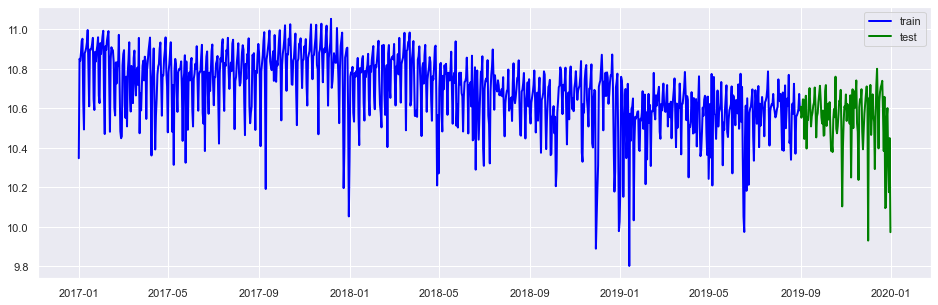

In [79]:
diario["cantidad_pasos"] = diario.y
diario.index= diario.ds
diario.drop(["ds","y"], axis=1, inplace=True)

train_size = int(len(diario.cantidad_pasos) * 0.889)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.show()

In [80]:
look_back = 60 # usamos dos meses de datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(121, 60) (121,)


In [81]:
tuned_parameters = {'n_estimators': [500, 700, 1000], 
                    'max_depth': [None, 1, 2, 3], 
                    'min_samples_split': [1, 2, 3]}

tscv = TimeSeriesSplit(n_splits=10)

clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=tscv, n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

print(clf.best_estimator_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.2min finished


RandomForestRegressor(min_samples_split=3, n_estimators=1000)


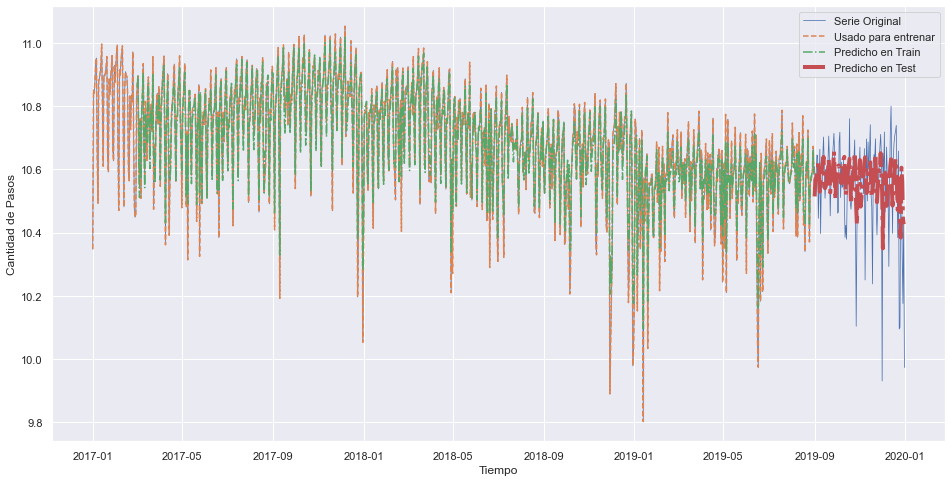

In [82]:
y_pred = clf.predict(X)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

In [83]:
MSE = mean_squared_error(np.exp(y_train), np.exp(y_train_pred))
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(np.exp(y_test), np.exp(y_test_pred))
print('Error en Test:',np.sqrt(MSE))

Error en Train: 1759.1283595479936
Error en Test: 4496.7847387137135


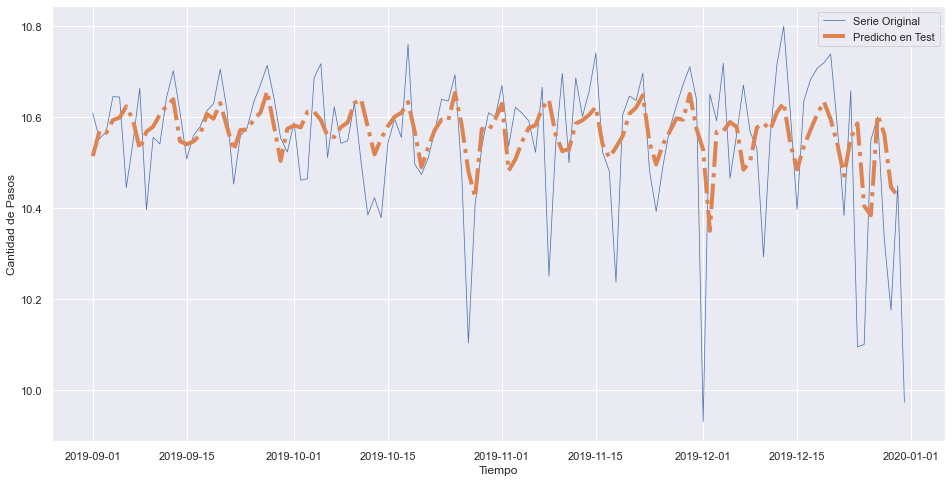

In [84]:
plt.figure(figsize=(16,8))
plt.plot(test.index[:length_total],test[:length_total],lw = 0.75, label = 'Serie Original')
#plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
#plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

La transformación de la serie tomando logaritmos sirve para solucionar el problema de Heterocedasticidad, su definición es la siguiente:
* La heterocedasticidad es, en estadística, cuando los errores no son constantes a lo largo de toda la muestra.
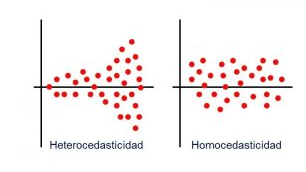

2.7 Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?

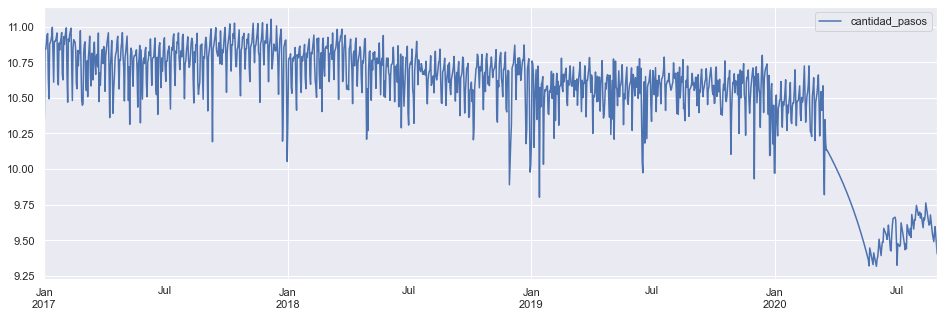

In [85]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

data_2020.drop(columns = ['periodo',"dia_fecha",'hora_inicio','forma_pago', 'estacion'], inplace = True)

data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

data_2020.drop(columns=['fecha','hora_fin'], inplace = True)
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

data_2020.sort_values('fecha', inplace = True)
data_2020.reset_index(drop=True, inplace = True)

data_2020 = data_2020.resample('D', on = 'fecha').sum()
data_2020.cantidad_pasos[data_2020.cantidad_pasos <= 10000] = np.nan
data_2020 = data_2020.interpolate()

data_2020 = np.log(data_2020)


diario = pd.concat([diario, data_2020])

diario.plot()

In [86]:
diario

cantidad_pasos
2017-01-01       10.347628
2017-01-02       10.850657
2017-01-03       10.841403
2017-01-04       10.884292
2017-01-05       10.941748
...                    ...
2020-08-27        9.549238
2020-08-28        9.595331
2020-08-29        9.535439
2020-08-30        9.471730
2020-08-31        9.403684

[1339 rows x 1 columns]

Observations: 1339
Training Observations: 1095
Testing Observations: 244


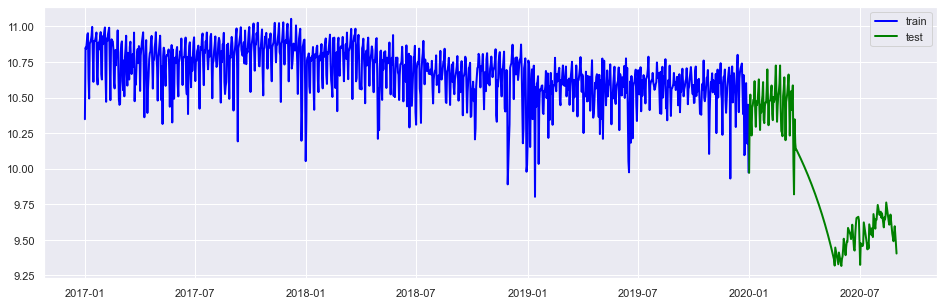

In [87]:
train_size = int(len(diario.cantidad_pasos) * 0.818)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.show()

In [88]:
diario.cantidad_pasos[0:train_size]

2017-01-01    10.347628
2017-01-02    10.850657
2017-01-03    10.841403
2017-01-04    10.884292
2017-01-05    10.941748
                ...    
2019-12-27    10.601174
2019-12-28    10.331399
2019-12-29    10.175764
2019-12-30    10.449381
2019-12-31     9.973340
Name: cantidad_pasos, Length: 1095, dtype: float64

In [89]:
look_back = 60 # usamos dos meses de datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]


N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(1035, 60) (1035,)
(243, 60) (243,)


In [90]:
diario.cantidad_pasos.index[N_train+look_back: length_total]

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29',
               '2020-08-30', '2020-08-31'],
              dtype='datetime64[ns]', length=244, freq=None)

Error en Train: 1782.0822744017064
Error en Test: 10768.948276338697


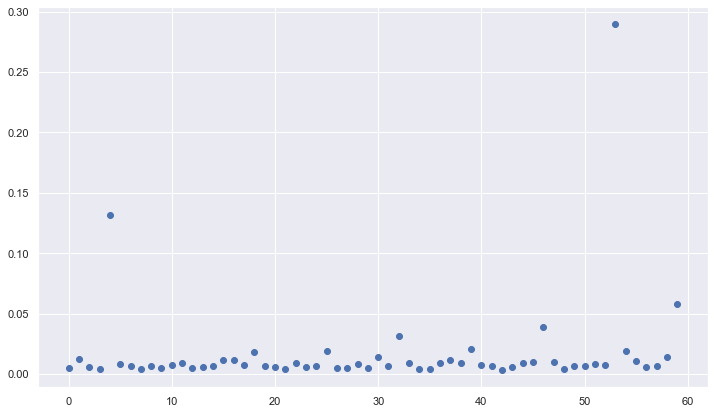

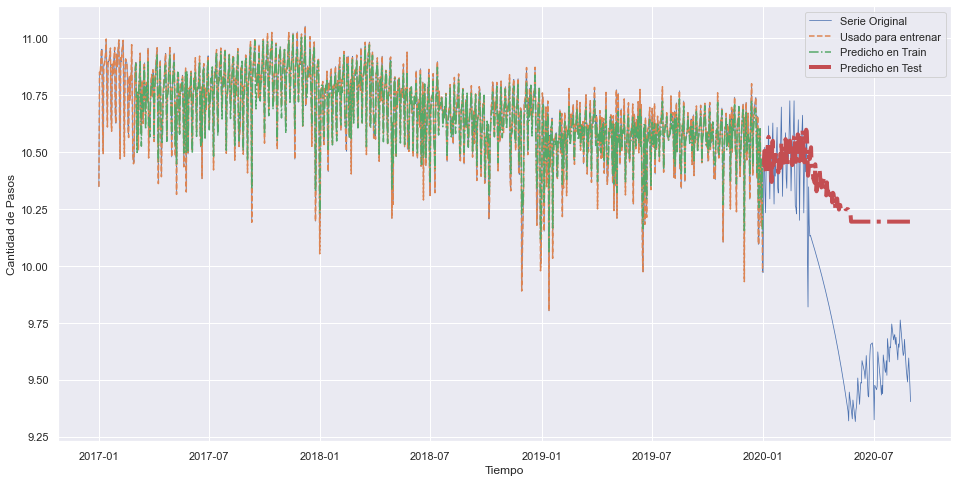

In [91]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)

plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)

y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

MSE = mean_squared_error(np.exp(y_train), np.exp(y_train_pred))
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(np.exp(y_test), np.exp(y_test_pred))
print('Error en Test:',np.sqrt(MSE))

plt.figure(figsize=(16,8))
plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[:N_train + look_back], diario.cantidad_pasos[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.cantidad_pasos.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(diario.cantidad_pasos.index[N_train+look_back: length_total-1], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

El modelo funciona mal por el gran shock que sufre la serie por el confinamiento para hacer frente al COVID-19. Es muy problable que para realizar estimaciones, hasta no retornar a una situación similar al perpiodo 2017-2019, no sea una buena idea estimar valores en base a valores del pasado.   

2.8 Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

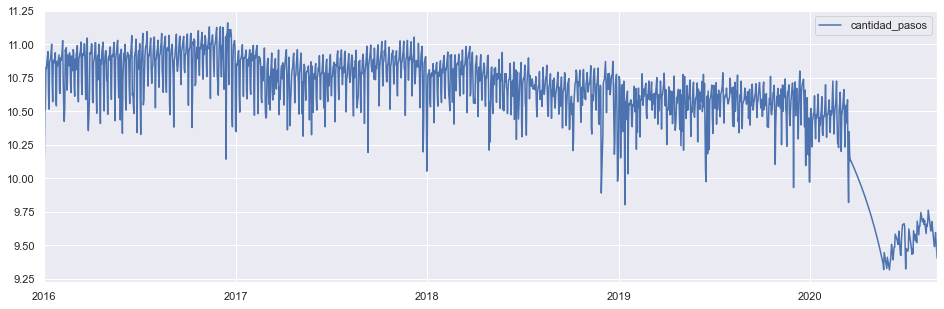

In [92]:
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')
mask = np.logical_and(data_2016.estacion=='Illia', data_2016.forma_pago == 'EFECTIVO')
data_2016 = data_2016[mask]

data_2016.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
data_2016['fecha2'] = pd.to_datetime(data_2016.fecha) + pd.to_timedelta(data_2016.hora_fin, unit = 'h')
data_2016.drop(columns=['fecha','hora_fin'], inplace = True)
data_2016.rename(columns = {'fecha2':'fecha'}, inplace = True) 

data_2016.sort_values('fecha', inplace = True)
data_2016.reset_index(drop=True, inplace = True)

data_2016 = data_2016.resample('D', on = 'fecha').sum()

data_2016.cantidad_pasos[data_2016.cantidad_pasos <= 10000] = np.nan
data_2016 = data_2016.interpolate()

data_2016 = np.log(data_2016)


diario = pd.concat([data_2016, diario])

diario.plot()

Observations: 1705
Training Observations: 1461
Testing Observations: 244


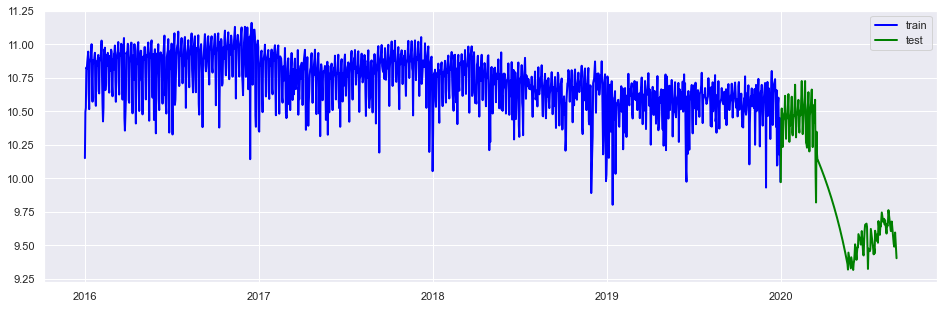

In [93]:
train_size = int(len(diario.cantidad_pasos) * 0.857)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.show()

In [94]:
test

cantidad_pasos
2020-01-01        9.970913
2020-01-02       10.425906
2020-01-03       10.520482
2020-01-04       10.329637
2020-01-05       10.233223
...                    ...
2020-08-27        9.549238
2020-08-28        9.595331
2020-08-29        9.535439
2020-08-30        9.471730
2020-08-31        9.403684

[244 rows x 1 columns]

In [95]:
look_back = 90 # usamos 90 datos para predecir el valor siguiente

N = diario.cantidad_pasos.shape[0]

X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)

for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

N_train = len(train.cantidad_pasos) - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = len(test.cantidad_pasos) #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

tuned_parameters = {'n_estimators': [500, 700, 1000], 
                    'max_depth': [None, 1, 2, 3], 
                    'min_samples_split': [1, 2, 3]}

tscv = TimeSeriesSplit(n_splits=10)

clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=tscv, n_jobs=-1, verbose=1)

clf.fit(X_train, y_train)

print(clf.best_estimator_)

(243, 90) (243,)
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  9.1min finished


RandomForestRegressor(min_samples_split=3, n_estimators=1000)


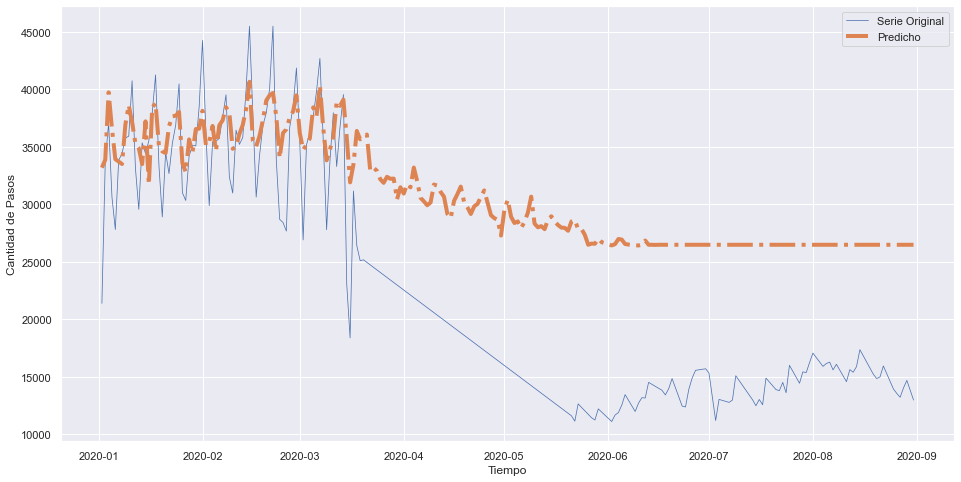

Error en Train: 1787.5576651556084
Error en Test: 10541.705478234935


In [96]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

plt.figure(figsize=(16,8))
plt.plot(diario.index[1462:], np.exp(y[1371:]),lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[1462:], np.exp(y_test_pred),'-.', lw = 4, label = 'Predicho')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de Pasos')
plt.show()

MSE = mean_squared_error(np.exp(y_train), np.exp(y_train_pred))
print('Error en Train:',np.sqrt(MSE))

MSE = mean_squared_error(np.exp(y_test), np.exp(y_test_pred))
print('Error en Test:',np.sqrt(MSE))

No mejoran al considerar datos del año 2016 para entrenar el modelo.

### Parte C - Para pensar, investigar y, opcionalmente, implementar

1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

Buscaría la forma de agregar dummies por los días de la semana, las cuales pueden agregar información predictiva al modelo, dado que es problable que los fines de semana sean días de baja (o alta) en la cantidad de pasos.

2. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?

In [97]:
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2016, data_2017, data_2018, data_2019,data_2020])
dataset.forma_pago = dataset.forma_pago.str.upper()
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = dataset.forma_pago == 'EFECTIVO'
dataset = dataset[mask]
dataset

periodo       fecha  hora_inicio  hora_fin      dia  \
3           2016  2016-01-01            1         2  Viernes   
5           2016  2016-01-01            1         2  Viernes   
8           2016  2016-01-01            2         3  Viernes   
9           2016  2016-01-01            2         3  Viernes   
12          2016  2016-01-01            3         4  Viernes   
...          ...         ...          ...       ...      ...   
1627953     2020  2020-08-31           18        19    Lunes   
1627976     2020  2020-08-31           19        20    Lunes   
1628002     2020  2020-08-31           20        21    Lunes   
1628006     2020  2020-08-31           20        21    Lunes   
1628049     2020  2020-08-31           22        23    Lunes   

                                 estacion    sentido   tipo_vehiculo  \
3                                 Alberdi     Centro         Liviano   
5                                 Alberdi     Centro         Liviano   
8                                 Alberdi     Centro         Liviano   
9                                 Alberdi     Centro         Liviano   
12                                Alberdi     Centro         Liviano   
...                                   ...        ...             ...   
1627953                        AVELLANEDA  Provincia  Pesados 6 Ejes   
1627976                        AVELLANEDA     Centro  Pesados 6 Ejes   
1628002                        AVELLANEDA  Provincia  Pesados 6 Ejes   
1628006  DELLEPIANE LINIERSLEPIANE CENTRO     Centro  Pesados 6 Ejes   
1628049                DELLEPIANE LINIERS  Provincia  Pesados 6 Ejes   

        forma_pago  cantidad_pasos     mes  dia_fecha observacion  
3         EFECTIVO               4     NaN        NaN         NaN  
5         EFECTIVO              94     NaN        NaN         NaN  
8         EFECTIVO               1     NaN        NaN         NaN  
9         EFECTIVO             119     NaN        NaN         NaN  
12        EFECTIVO               1     NaN        NaN         NaN  
...            ...             ...     ...        ...         ...  
1627953   EFECTIVO               1  agosto       31.0    Efectivo  
1627976   EFECTIVO               1  agosto       31.0    Efectivo  
1628002   EFECTIVO               1  agosto       31.0    Efectivo  
1628006   EFECTIVO               1  agosto       31.0    Efectivo  
1628049   EFECTIVO               1  agosto       31.0    Efectivo  

[1644842 rows x 13 columns]

In [98]:
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'tipo_vehiculo',"sentido","mes","dia_fecha", "observacion"], inplace = True)
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')
dataset.drop(columns=['fecha','hora_fin',"dia"], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.estacion = dataset.estacion.str.upper()

In [99]:
dataset.estacion = dataset.estacion.replace('DELLEPIANE LINIERS', 'DELLEPIANE')
dataset.estacion = dataset.estacion.replace('DELLEPIANE CENTRO', 'DELLEPIANE')
dataset.estacion = dataset.estacion.replace('DELLEPIANE LINIERSLEPIANE CENTRO', 'DELLEPIANE')
dataset.estacion = dataset.estacion.replace('ALBERTI', 'ALBERDI')
dataset.estacion.unique()


array(['ALBERDI', 'ILLIA', 'RETIRO', 'DELLEPIANE', 'AVELLANEDA'],
      dtype=object)

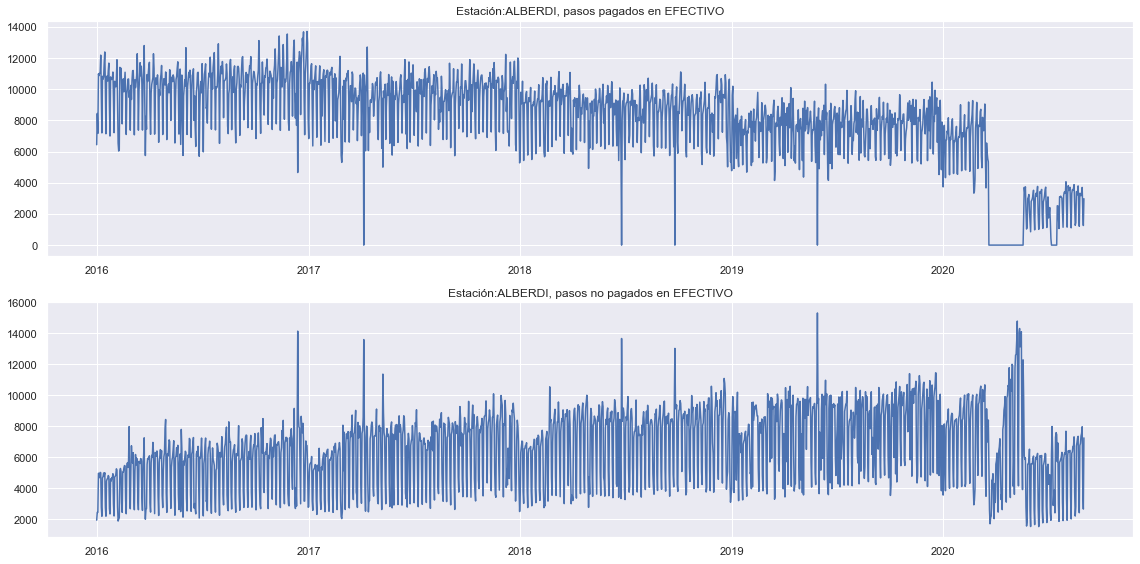

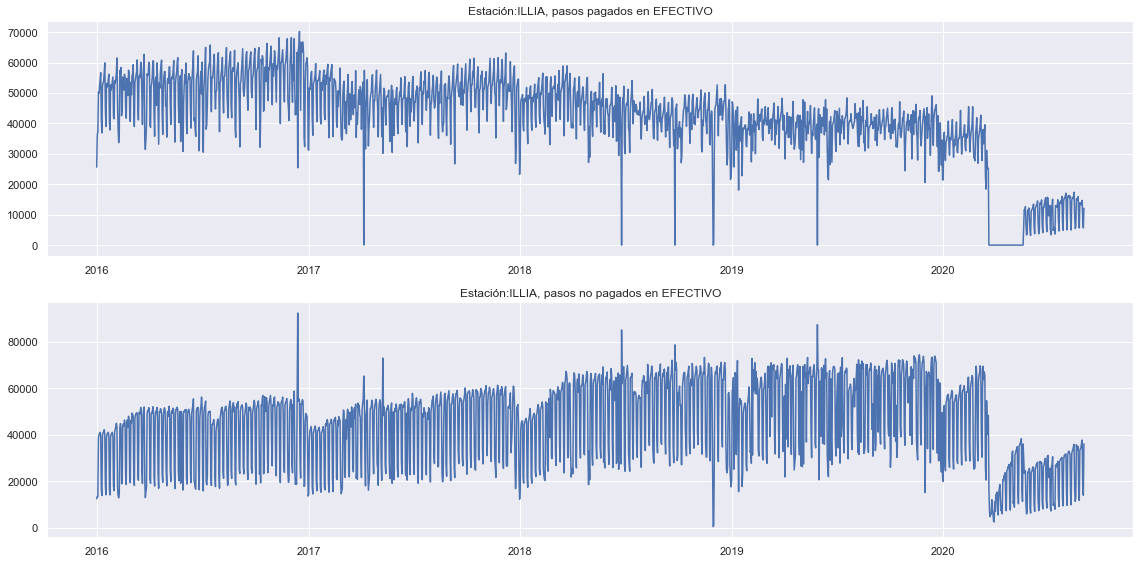

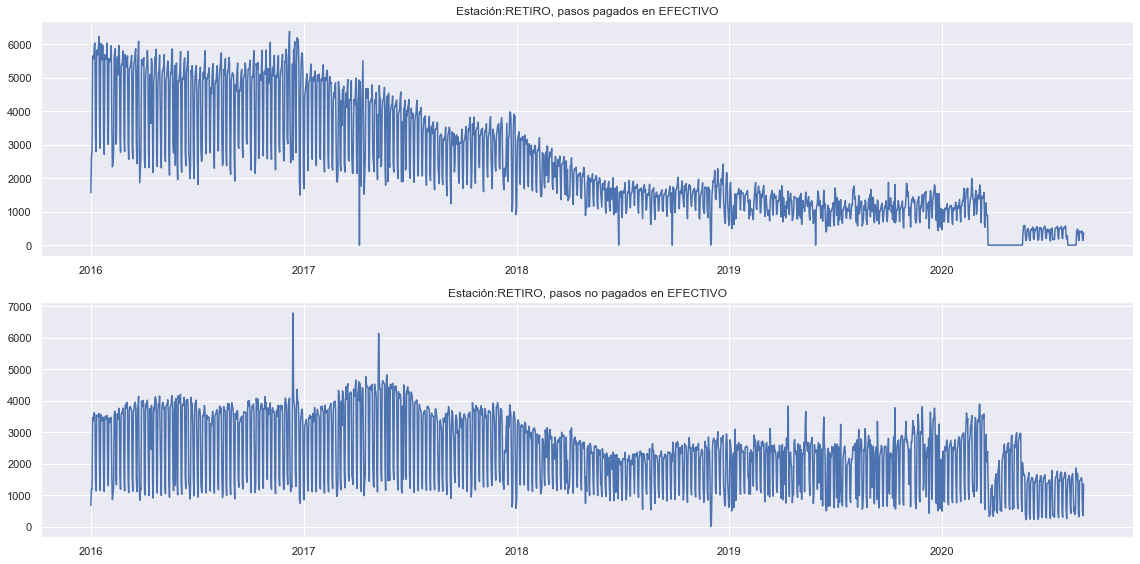

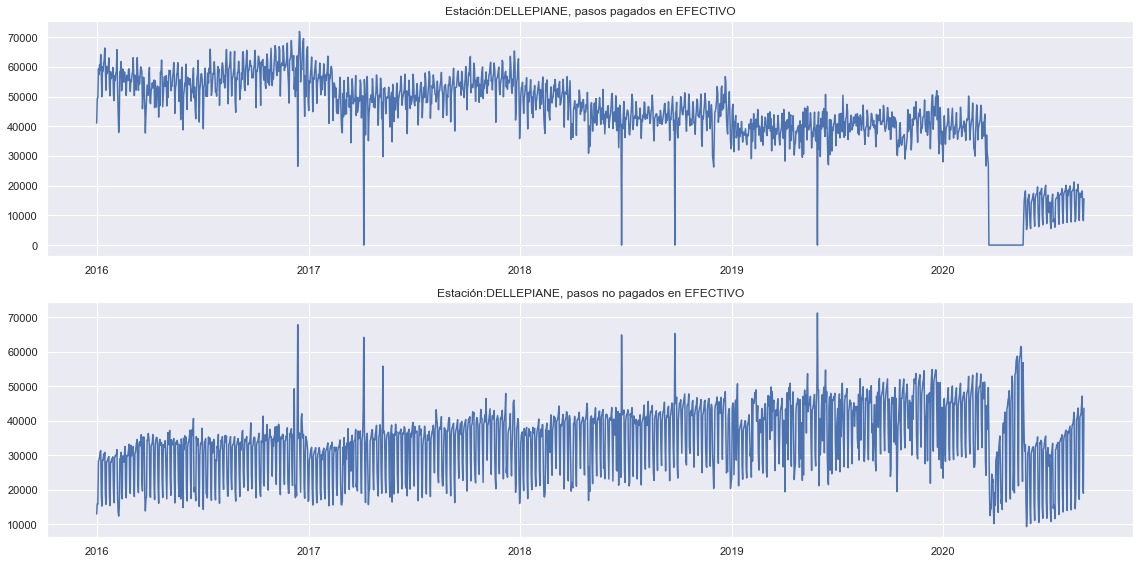

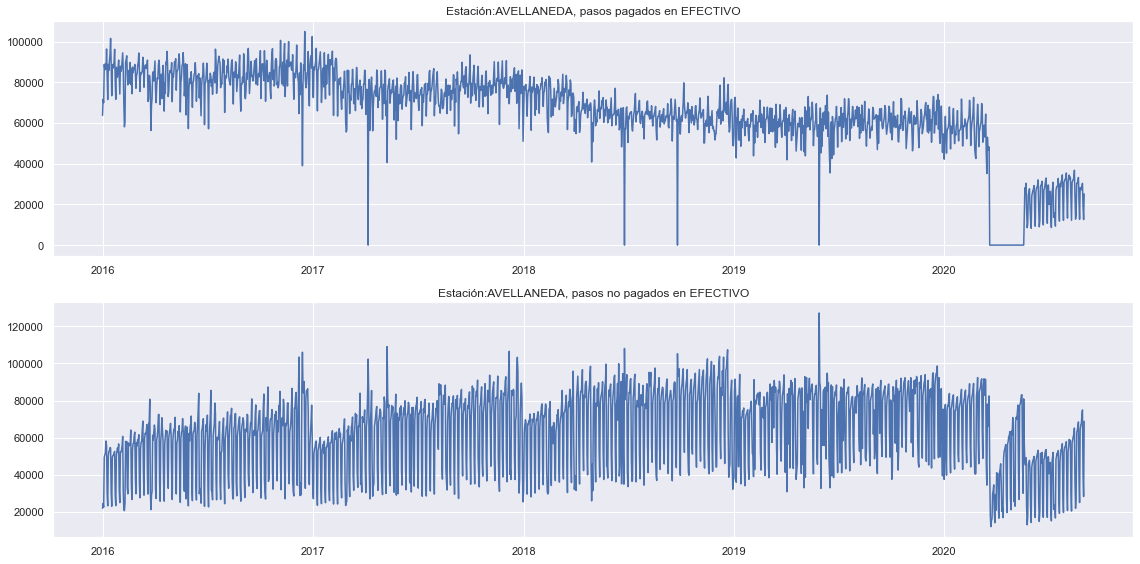

In [100]:
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2016, data_2017, data_2018, data_2019,data_2020])

dataset.drop(columns = ['periodo','hora_inicio', 'tipo_vehiculo',"sentido","mes","dia_fecha", "observacion"], inplace = True)
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')
dataset.drop(columns=['fecha','hora_fin',"dia"], inplace = True)
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.estacion = dataset.estacion.str.upper()

dataset.forma_pago = dataset.forma_pago.str.upper()

dataset.estacion = dataset.estacion.replace('DELLEPIANE LINIERS', 'DELLEPIANE')
dataset.estacion = dataset.estacion.replace('DELLEPIANE CENTRO', 'DELLEPIANE')
dataset.estacion = dataset.estacion.replace('DELLEPIANE LINIERSLEPIANE CENTRO', 'DELLEPIANE')
dataset.estacion = dataset.estacion.replace('ALBERTI', 'ALBERDI')


for i in ['ALBERDI', 'ILLIA', 'RETIRO', 'DELLEPIANE', 'AVELLANEDA']:
    data = dataset[dataset["estacion"]==i] 
    data2 = dataset[np.logical_and(dataset["estacion"]==i, dataset["forma_pago"]=="EFECTIVO")]
    data = data.resample('D', on = 'fecha').sum()
    data2 = data2.resample('D', on = 'fecha').sum()
    #data[data.cantidad_pasos <= 100] = np.nan
    fig, (ax1, ax2) = plt.subplots(2, figsize=(16,8))
    ax1.plot(data2)
    ax1.set_title(f"Estación:{i}, pasos pagados en EFECTIVO")
    
    ax2.plot(data.cantidad_pasos - data2.cantidad_pasos)
    ax2.set_title(f"Estación:{i}, pasos no pagados en EFECTIVO")
    plt.tight_layout()
    plt.show()

Si bien vemos un shock los dias de cuarentena, podemos observar una leve tendencia decreciente al pago de los pasos en EFECTIVO en todas las estaciones, mientras se mantiene la tendencia de los pasos en total (al menos entre 2016 y 2019). 
Esto que implica que si la serie total tiene tendencia nula, relativamente el peso de los pasos en efectivo esta en caída frente a los demás pagos.

La serie que se destaca frente a las demás, es la correspondiente a la estación RETIRO, la cual en 2017 comienza un decrecimiento muy fuerte que luego se estabiliza en un nivel mas bajo en el año 2019.

3. ¿Hay algo que te gustaría investigar o probar?

En un segundo desarrollo quisiera probar una metodología llamada ARIMA, la cual es una metodología econométrica basada en modelos dinámicos que utiliza datos de series temporales.

La metodología utilizada en los modelos ARIMA fue descrita inicialmente por el estadístico George Edward Pelham Box y el estadístico e ingeniero Gwilym Meirion Jenkins en 1970 en su libro: Análisis de series temporales. Predicción y control (Time Series Análisis: Forecasting and Control).

Para más información pueden acceder a https://guiasjuridicas.wolterskluwer.es/Content/Documento.aspx?params=H4sIAAAAAAAEAMtMSbF1jTAAASMTc1MLtbLUouLM_DxbIwMDS0NDQ3OQQGZapUt-ckhlQaptWmJOcSoADzPwXjUAAAA=WKE 